In [124]:
import random
import numpy as np
import torch
from torch import nn
import torch.optim as optim

# multivariate data preparation
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt

import joblib 

In [125]:
data = np.loadtxt('./../tower_prep_data.csv', delimiter=',', dtype=np.float32, skiprows=1)

In [126]:
scaler_vibrations = joblib.load('./scalers/motor.gz')
scaler_temperature = joblib.load('./scalers/temperature.gz')
scaler_temperature_pir = joblib.load('./scalers/temperature_pir.gz')
scaler_start_stop = joblib.load('./scalers/start_stop.gz')

In [127]:
train_window = 60 * 160 #10000
offset = -1

In [128]:
train_window = 3000

In [129]:
dataset = data[: 10000, 3:-1]
type(dataset)

numpy.ndarray

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler3 = MinMaxScaler(feature_range=(-1, 1))
vibrations = scaler3.fit_transform(dataset[:, 0] .reshape(-1, 1))

scaler4 = MinMaxScaler(feature_range=(-1, 1))
temperature = scaler4.fit_transform(dataset[:, 1] .reshape(-1, 1))

scaler6 = MinMaxScaler(feature_range=(-1, 1))
temperature_pir = scaler6.fit_transform(dataset[:, 2] .reshape(-1, 1))

In [130]:
vibrations = scaler_vibrations.transform(np.log( dataset[:offset, 0] + 1e-15).reshape(-1, 1))
temperature = scaler_temperature.transform(dataset[:offset, 1] .reshape(-1, 1))
#temperature_pir = scaler_temperature_pir.transform(dataset[:offset, 2] .reshape(-1, 1))
#temperature = dataset[:offset, 1]/100
temperature_pir = dataset[:offset, 2]/50

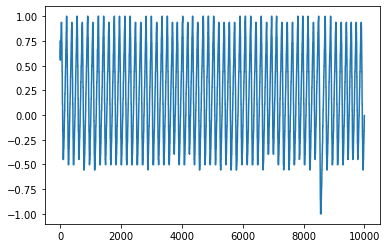

In [131]:
plt.plot(temperature[:])

In [132]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        
        super(NeuralNetwork, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
        
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 6)
        )
        
    
    def forward(self, x):
        
        output = self.linear_relu_stack(x)
        return output

In [133]:
motor_model = torch.load("./models/motor.pt")

In [61]:
motor_model.eval()

with torch.no_grad():
    
    outputs = torch.tensor(vibrations[-60:].reshape(-1, 60))

    outputs = motor_model(outputs)
    _, predicted = torch.max(outputs, 1)

In [134]:
def motor_eval(vib):
    motor_model.eval()

    with torch.no_grad():

        outputs = torch.tensor(vib.reshape(-1, 60))

        outputs = motor_model(outputs)
        _, predicted = torch.max(outputs, 1)
        
        return predicted.item()

In [149]:
pred_vibrations = np.array([])

for i in range(vibrations.size - 60):
    
    pred_vibrations = np.append(pred_vibrations, motor_eval( vibrations[i : i + 60])/5)
    #print(motor_eval( vibrations[i : i + 60]))
    

In [150]:
pred_vibrations.size

9939

In [151]:
temperature.size

9999

In [152]:
dataset = np.stack((pred_vibrations, temperature[60:, 0], temperature_pir[60:]), axis=1)
#dataset = temperature[:, 0]

In [153]:
dataset[:10]

array([[1.        , 0.72444725, 0.3976    ],
       [0.8       , 0.72444725, 0.3976    ],
       [1.        , 0.72444725, 0.3976    ],
       [0.8       , 0.6400013 , 0.3976    ],
       [1.        , 0.55555534, 0.3976    ],
       [0.8       , 0.55555534, 0.3976    ],
       [0.8       , 0.55555534, 0.3976    ],
       [1.        , 0.49777985, 0.3976    ],
       [0.6       , 0.44000244, 0.3976    ],
       [0.8       , 0.44000244, 0.3976    ]])

In [154]:
len(dataset)

9939

In [155]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 30 # number of hidden states
        self.n_layers = 4 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [156]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences) - 1):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences) - 1:
            break
        
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, 1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

(9879, 60, 3) (9879,)
step :  0 loss :  0.20097655057907104
step :  1 loss :  0.018640000373125076
step :  2 loss :  0.01441149227321148
step :  3 loss :  0.010581511072814465
step :  4 loss :  0.0070358398370444775
step :  5 loss :  0.004157530143857002
step :  6 loss :  0.003114064922556281
step :  7 loss :  0.0035528994631022215
step :  8 loss :  0.004594507627189159
step :  9 loss :  0.006380797829478979
tensor([0.0179])


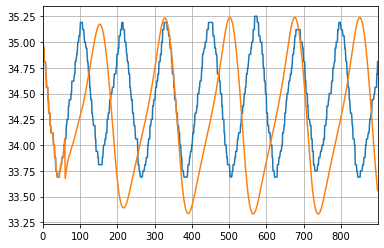

step :  0 loss :  0.007210931740701199
step :  1 loss :  0.005012902431190014
step :  2 loss :  0.003530674148350954
step :  3 loss :  0.0031251516193151474
step :  4 loss :  0.0029972682241350412
step :  5 loss :  0.0029383739456534386
step :  6 loss :  0.0029131004121154547
step :  7 loss :  0.002907718997448683
step :  8 loss :  0.0029054065234959126
step :  9 loss :  0.002898950595408678
tensor([0.0171])


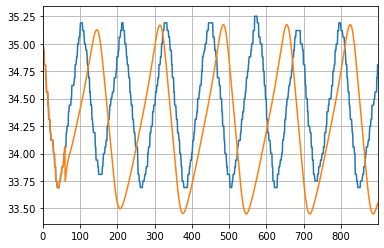

KeyboardInterrupt: 

In [161]:
n_features = 3 # this is number of parallel inputs
n_timesteps = 60 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(dataset, n_timesteps)
print(X.shape, y.shape)

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=0.001)

train_episodes = 10
batch_size = 500

accuracy = 1

while(accuracy > 0.005):
    
    mv_net.train()
    for t in range(train_episodes):
        for b in range(0,len(X),batch_size):
            inpt = X[b:b+batch_size,:,:]
            target = y[b:b+batch_size]    

            x_batch = torch.tensor(inpt,dtype=torch.float32)    
            y_batch = torch.tensor(target,dtype=torch.float32)
            #print(x_batch)
            mv_net.init_hidden(x_batch.size(0))
        #    lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
        #    lstm_out.contiguous().view(x_batch.size(0),-1)
            output = mv_net(x_batch) 
            loss = criterion(output.view(-1), y_batch)  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad() 
        print('step : ' , t , 'loss : ' , loss.item())
    
    
    
    fut_pred = 900

    dataset_test = data[-train_window:, 3:-1].copy()#.tolist()
    dataset_test_l = data[-train_window:, 3:-1].tolist()


    #vibrations = scaler3.transform(dataset[:, 0] .reshape(-1, 1))
    #temperature = scaler4.transform(dataset_test[:, 1] .reshape(-1, 1))
    #temperature_pir = scaler6.transform(dataset_test[:, 2] .reshape(-1, 1))
    #vibrations = scaler_vibrations.fit_transform(np.log( dataset[:, 0] + 1e-15).reshape(-1, 1))
    
    vibrations = scaler_vibrations.transform(np.log( dataset_test[:, 0] + 1e-15).reshape(-1, 1))
    temperature = scaler_temperature.transform(dataset_test[:, 1] .reshape(-1, 1))
    #temperature_pir = scaler_temperature_pir.transform(dataset_test[:, 2] .reshape(-1, 1))
    
    #temperature = dataset_test[:, 1]/100
    temperature_pir = dataset_test[:, 2]/50
    
    #for x in range(len(temperature)):
        #dataset_test[x] = [vibrations[x][0], temperature[x][0], temperature_pir[x][0]]
     #   dataset_test[x] = [temperature[x][0], temperature_pir[x][0]]
    
    dataset_test = []

    #for x in range(len(temperature)):
    #    dataset_test.append([temperature[x][0], temperature_pir[x][0]])

    #dataset_test = np.array(dataset_test)
    pred_vibrations = np.empty(temperature.size)
    pred_vibrations.fill(motor_eval(vibrations[:60])/5)
    
    pred_temperature = np.empty(temperature.size)
    pred_temperature.fill( temperature_pir[0] )
    
    dataset_test = np.stack((pred_vibrations, temperature[:, 0], temperature_pir), axis=1)
    

    mv_net.eval()

    for i in range(fut_pred):

        seq = torch.FloatTensor([ dataset_test[i: i + n_timesteps]])
        #print(seq)
        
        #print(seq)

        with torch.no_grad():

            mv_net.init_hidden(seq.size(0))
            dataset_test[i + n_timesteps] = [dataset_test[i + n_timesteps][0], mv_net(seq).item(), dataset_test[i + n_timesteps][2]]


    dataset_test = torch.FloatTensor(dataset_test)
    dataset_test_l = torch.FloatTensor(dataset_test_l)
    temp = scaler_temperature.inverse_transform(np.array(dataset_test[:fut_pred, 1] ).reshape(-1, 1))
    

    sum = 0
    for i in range(fut_pred):

        sum += abs(dataset_test_l[i, 1] - temp[i]) / dataset_test_l[i, 1]

    accuracy = sum / fut_pred
    print(accuracy)
    
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(dataset_test_l[:fut_pred, 1])
    plt.plot(temp)
    #plt.plot(dataset_test[:fut_pred, 1])
    #plt.plot(temperature[:fut_pred])
    plt.show()


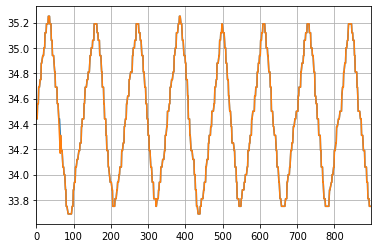

In [88]:
plt.grid(True)
plt.autoscale(axis='x', tight=True)
#plt.plot(dataset_test_l[:fut_pred, 1])
plt.plot(temp)
#plt.plot(dataset_test[:fut_pred, 1])
#plt.plot(temperature[:fut_pred])
plt.show()

In [ ]:
torch.save(mv_net, "./models/temperature2.pt")

In [11]:
torch.save(mv_net, "./models/temperature.pt")

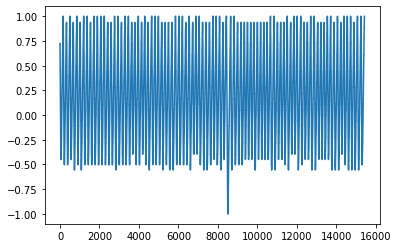

In [93]:
plt.plot(y)